In [1]:
import numpy as np

from probts.data.data_utils.data_scaler import Scaler, StandardScaler

from probts.model.forecaster import LinearForecaster, NaiveForecaster
from probts.model.forecast_module import ProbTSForecastModule
from probts.data import ProbTSDataModule, DataManager, ProbTSBatchData
from probts.utils import find_best_epoch
from lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
import torch
import matplotlib.pyplot as plt

In [2]:
class BinaryQuantizer(Scaler):
    def __init__(self, num_bins=2000, min_val=-3.0, max_val=3.0):
        super().__init__()
        self.num_bins = num_bins
        self.min_val = min_val
        self.max_val = max_val
        self.bin_values_ = torch.linspace(self.min_val, self.max_val, self.num_bins)

    def fit(self, values):
        self.min_val = values.min()
        self.max_val = values.max()
        self.bin_values_ = torch.linspace(self.min_val, self.max_val, self.num_bins)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

    def transform(self, values):
        bin_thresholds = self.bin_values_.reshape(1, 1, -1)
        return (values >= bin_thresholds).float()

    def inverse_transform(self, values):
        reversed_bin = torch.flip(values, dims=(-1,))
        idx_first_one_reversed = reversed_bin.argmax(axis=-1)[..., None]
        idx_last_one = self.num_bins - 1 - idx_first_one_reversed
        reconstructed = self.bin_values_[idx_last_one]
        return reconstructed

In [3]:
class StandardBinScaler(Scaler):
    def __init__(self, standard: StandardScaler, bin: BinaryQuantizer):
        super().__init__()
        self.standard = standard
        self.bin = bin

    def fit(self, X):
        Z = self.standard.fit_transform(X)
        self.bin.fit(Z)
        print('the scaler was fitted')

    def transform(self, X):
        Z = self.standard.transform(X)
        return self.bin.transform(Z)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        Z = self.bin.inverse_transform(X)
        return self.standard.inverse_transform(Z)

In [4]:
# data_manager = DataManager(
#     dataset='tourism_monthly',
#     path='../datasets',
#     context_length=12,
#     prediction_length=12,
# )
# data_manager.context_length

In [5]:
class CustomDataManager(DataManager):
    def _configure_scaler(self, scaler_type: str):
        """Configure the scaler."""
        if scaler_type == "standard":
            return StandardScaler(var_specific=self.var_specific_norm)
        elif scaler_type == "temporal":
            return TemporalScaler()
        elif scaler_type == "binary":
            return BinaryQuantizer()
        elif scaler_type == "standard_binary":
            return StandardBinScaler(StandardScaler(var_specific=self.var_specific_norm), BinaryQuantizer())
        return IdentityScaler()

In [6]:
# data_module = ProbTSDataModule(
#     data_manager=data_manager,
#     batch_size=32,
#     test_batch_size=32,
#     num_workers=8,
# )
# test_dataloader = data_module.test_dataloader()
# train_dataloader = data_module.train_dataloader()
# val_dataloader = data_module.val_dataloader()

In [7]:
# for test_batch in test_dataloader:
#     break

In [8]:
# batch_data = ProbTSBatchData(test_batch, 'cpu')
# batch_data.past_target_cdf.shape

In [9]:
# plt.figure(figsize=(10,3))
# plt.plot(batch_data.past_target_cdf[13, :, 0].t())
# plt.show()

In [10]:
# scaler = StandardBinScaler(StandardScaler(), BinaryQuantizer())
# scaler.fit(batch_data.past_target_cdf)
# transformed = scaler.transform(batch_data.past_target_cdf)
# transformed.shape

In [11]:
# plt.figure(figsize=(10,3))
# plt.imshow(transformed[13].T, aspect='auto', interpolation='none', cmap='Reds')
# plt.show()

In [12]:
# reconstructed = scaler.inverse_transform(transformed)
# reconstructed.shape

In [13]:
# plt.figure(figsize=(10,3))
# plt.plot(reconstructed[13, :, 0].t())
# plt.show()


In [14]:
data_manager = CustomDataManager(
    dataset='m4_daily',
    path='../datasets',
    context_length=72,
    prediction_length=24,
    scaler="standard_binary",
)

# data_manager = DataManager(
#     dataset='m4_daily',
#     # dataset='etth1',
#     path='./datasets',
#     context_length=12,
#     prediction_length=12,
#     scaler="standard_binary",
# )

Loading Short-term Dataset: m4_daily
No validation set is used.


In [15]:
# data_manager.dataset_raw.training_dataset

In [16]:
data_manager.context_length

72

In [17]:
data_module = ProbTSDataModule(
    data_manager=data_manager,
    batch_size=1,
    test_batch_size=1,
    num_workers=8,
)
test_dataloader = data_module.test_dataloader()
train_dataloader = data_module.train_dataloader()
val_dataloader = data_module.val_dataloader()

In [18]:
for test_batch in test_dataloader:
    break

In [19]:
test_batch['past_target_cdf'].shape

torch.Size([1, 86])

In [20]:
test_batch['past_target_cdf'].reshape(-1,1).shape

torch.Size([86, 1])

In [21]:
data_manager.scaler.standard.mean

In [22]:
data_manager.scaler.transform(test_batch['past_target_cdf'].reshape(-1,1))

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [23]:
# for train_batch in train_dataloader:
#     break

In [24]:
# batch_data = ProbTSBatchData(test_batch, 'cpu')
# batch_data.past_target_cdf.shape

In [25]:
data_manager.context_length

72

In [26]:
def sliding_window_batch(x, L, H):
    """
    x: Tensor of shape (B, L+H, C)
    Returns: Tensor of shape (B, H, L, C)
    """
    B, total_len, C = x.shape
    assert total_len >= L + H, "Not enough sequence length for given L and H"

    windows = [x[:, h:h + L, :].unsqueeze(1) for h in range(H)]  # list of (B, 1, L, C)
    return torch.cat(windows, dim=1)  # (B, H, L, C)

In [27]:
def most_probable_monotonic_sequence(p: torch.Tensor):
    """
    p: Tensor of shape (B, D) where each row is a probability vector
    Returns:
        best_sequences: Tensor of shape (B, D) with most probable [1...1, 0...0] sequence per batch
        best_probs: Tensor of shape (B,) with normalized probability of each best sequence
    """
    B, D = p.shape

    # Compute cumulative product of p and (1 - p)
    left_cumprod = torch.cumprod(p, dim=1)  # shape (B, D)
    right_cumprod = torch.cumprod((1 - p).flip(dims=[1]), dim=1).flip(dims=[1])  # shape (B, D)

    # Pad left with 1 at the beginning (per batch)
    ones = torch.ones((B, 1), dtype=p.dtype, device=p.device)
    left = torch.cat([ones, left_cumprod[:, :-1]], dim=1)  # shape (B, D)
    right = right_cumprod  # shape (B, D)

    # Element-wise multiply
    probs = left * right  # shape (B, D)

    # Normalize
    probs_sum = probs.sum(dim=1, keepdim=True)  # shape (B, 1)
    probs_normalized = probs / probs_sum

    # Find best cut index per batch
    best_k = torch.argmax(probs_normalized, dim=1)  # shape (B,)

    # Construct best sequences
    arange = torch.arange(D, device=p.device).unsqueeze(0)  # shape (1, D)
    best_k_expanded = best_k.unsqueeze(1)  # shape (B, 1)
    best_sequences = (arange < best_k_expanded).to(p.dtype)  # shape (B, D)

    # Get best normalized probabilities
    best_probs = torch.gather(probs_normalized, dim=1, index=best_k.unsqueeze(1)).squeeze(1)  # shape (B,)

    return best_sequences, best_probs

In [28]:
from probts.model.forecaster import Forecaster
from torch import nn
import torch.nn.functional as F


class BinConv(Forecaster):
    def __init__(self, context_length: int, num_bins: int, kernel_size_across_bins_2d: int = 3,
                 kernel_size_across_bins_1d: int = 3, num_filters_2d: int = 8,
                 num_filters_1d: int = 32, is_cum_sum: bool = False, **kwargs) -> None:
        """
        Initialize the model with parameters.
        """
        super().__init__(context_length=context_length, **kwargs)
        # Initialize model parameters here
        self.context_length = context_length
        self.num_bins = num_bins
        self.num_filters_2d = num_filters_2d
        self.num_filters_1d = num_filters_1d
        self.kernel_size_across_bins_2d = kernel_size_across_bins_2d
        self.kernel_size_across_bins_1d = kernel_size_across_bins_1d
        self.is_cum_sum = is_cum_sum

        # Conv2d over (context_length, num_bins)
        self.conv = nn.Conv2d(
            in_channels=1,
            out_channels=self.num_filters_2d,
            kernel_size=(context_length, kernel_size_across_bins_2d),
            bias=True
        )

        self.conv1d_1 = nn.Conv1d(
            in_channels=self.num_filters_2d,
            out_channels=self.num_filters_1d,
            kernel_size=kernel_size_across_bins_1d,
            bias=True
        )

        self.conv1d_2 = nn.Conv1d(
            in_channels=self.num_filters_1d,
            out_channels=self.num_bins,
            kernel_size=kernel_size_across_bins_1d,
            bias=True
        )

    # def forward(self, inputs):
    #     """
    #     Forward pass for the model.
    #
    #     Parameters:
    #     inputs [Tensor]: Input tensor for the model.
    #
    #     Returns:
    #     Tensor: Output tensor.
    #     """
    #     # Perform the forward pass of the model
    #     return outputs

    def forward(self, x):
        def pad_channels(tensor, pad_size: int, pad_val_left=1.0, pad_val_right=0.0):
            if pad_size == 0:
                return tensor
            left = torch.full((*tensor.shape[:-1], pad_size), pad_val_left, device=tensor.device)
            right = torch.full((*tensor.shape[:-1], pad_size), pad_val_right, device=tensor.device)
            return torch.cat([left, tensor, right], dim=-1)

        x = x.float()
        # x: (batch_size, context_length, num_bins)
        batch_size, context_length, num_bins = x.shape
        assert context_length == self.context_length, "Mismatch in context length"

        pad2d = self.kernel_size_across_bins_2d // 2 if self.kernel_size_across_bins_2d > 1 else 0
        x_padded = pad_channels(x, pad2d)
        x_conv_in = x_padded.unsqueeze(1)
        conv_out = F.relu(self.conv(x_conv_in).squeeze(2))  # (batch_size, num_filters_2d, num_bins)

        pad1d = self.kernel_size_across_bins_1d // 2 if self.kernel_size_across_bins_1d > 1 else 0
        h_padded = pad_channels(conv_out, pad1d)
        h = F.relu(self.conv1d_1(h_padded))

        h_padded = pad_channels(h, pad1d)
        out = self.conv1d_2(h_padded).mean(dim=1)  # (batch_size, num_bins)

        if self.is_cum_sum:
            out = torch.flip(torch.cumsum(torch.flip(out, dims=[1]), dim=1), dims=[1])
        return out

    def loss(self, batch_data):
        """
        Compute the loss for the given batch data.

        Parameters:
        batch_data [dict]: Dictionary containing input data and possibly target data.

        Returns:
        Tensor: Computed loss.
        """
        # Extract inputs and targets from batch_data

        inputs = self.get_inputs(batch_data, 'all')
        # print(f'bool:{torch.allclose(inputs[:, -self.prediction_length:, :], batch_data.future_target_cdf.float())}')
        inputs = sliding_window_batch(inputs, self.context_length, self.prediction_length).float()
        outputs = self(inputs.view(-1, *inputs.shape[2:]))
        # outputs = outputs[:, -self.prediction_length-1:-1, ...]
        target = batch_data.future_target_cdf.float()
        loss = F.binary_cross_entropy_with_logits(input=outputs, target=target.view(-1, *target.shape[2:]),)
        print(loss)
        return loss

    def forecast(self, batch_data, num_samples=None):
        inputs = self.get_inputs(batch_data, 'encode')
        current_context = inputs.clone()
        forecasts = []
        for _ in range(self.prediction_length):
            pred = F.sigmoid(self(current_context))  # (B, D)
            # pred = (pred >= 0.5).int()
            pred, _ = most_probable_monotonic_sequence(pred)
            pred = pred.int()
            forecasts.append(pred.unsqueeze(1))  # (B, 1, D)
            next_input = pred.unsqueeze(1)
            current_context = torch.cat([current_context[:, 1:], next_input], dim=1)

        return torch.cat(forecasts, dim=1)  # (B, T, D)

    # def forecast(self, batch_data, num_samples=None):
    #     """
    #     Generate forecasts for the given batch data.
    #
    #     Parameters:
    #     batch_data [dict]: Dictionary containing input data.
    #     num_samples [int, optional]: Number of samples per distribution during evaluation. Defaults to None.
    #
    #     Returns:
    #     Tensor: Forecasted outputs.
    #     """
    #     # Perform the forward pass to get the outputs
    #     outputs = self(batch_data.past_target_cdf[:, -self.context_length:, :])
    #     print(f'num samples:{num_samples}')
    #     if num_samples is not None:
    #         # If num_samples is specified, use it to sample from the distribution
    #         outputs = self.sample_from_distribution(outputs, num_samples)
    #     else:
    #         # If perform point estimation, the num_samples is equal to 1
    #         outputs = outputs.unsqueeze(1)
    #     return outputs  # [batch_size, num_samples, prediction_length, var_num]

In [29]:
data_manager.context_length

72

In [30]:
forecaster = BinConv(
    num_bins=1000,
    kernel_size_across_bins_2d=1,
    kernel_size_across_bins_1d=21,
    num_filters_2d=32,
    num_filters_1d=32,
    individual=True,
    use_lags=False,
    use_feat_idx_emb=False,
    use_time_feat=False,
    target_dim=data_manager.target_dim,
    context_length=data_manager.context_length,
    prediction_length=data_manager.prediction_length,
    freq=data_manager.freq,
    lags_list=data_manager.lags_list,
    time_feat_dim=data_manager.time_feat_dim,
    dataset=data_manager.dataset,
)
model = ProbTSForecastModule(
    forecaster=forecaster,
    scaler=data_manager.scaler,
    learning_rate=0.005,
    quantiles_num=20,
    num_samples=None
)

sampling_weight_scheme: none


/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'forecaster' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['forecaster'])`.


In [31]:
trainer = Trainer(
    accelerator="cpu",
    devices=1,
    strategy="auto",
    max_epochs=10,
    use_distributed_sampler=False,
    limit_train_batches=100,
    log_every_n_steps=1,
    accumulate_grad_batches=8,
    default_root_dir='./results',
    logger=CSVLogger('./logs'),
)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [32]:
target = []
for data in list(data_manager.dataset_raw.train):
    target.append(data['target'])

In [33]:
import numpy as np
model.scaler.fit(torch.tensor(np.concatenate(target)))

the scaler was fitted


In [34]:
model.scaler.standard.mean

tensor(5687.2070)

In [35]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


  | Name       | Type    | Params | Mode 
-----------------------------------------------
0 | forecaster | BinConv | 696 K  | train
-----------------------------------------------
696 K     Trainable params
0         Non-trainable params
696 K     Total params
2.787     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/andreichernov/miniforge3/envs/probts/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6938, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6939, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6516, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6513, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6511, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6511, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6513, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6512, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.6513, grad_fn=<BinaryCrossEntro

`Trainer.fit` stopped: `max_epochs=10` reached.


In [44]:
import pandas as pd
df = pd.read_csv('logs/lightning_logs/version_83/metrics.csv')
df.groupby('step').agg({'train_loss': 'mean'})

FileNotFoundError: [Errno 2] No such file or directory: 'logs/lightning_logs/version_83/metrics.csv'

In [102]:
i=0
for test_batch in train_dataloader:
    if i> 1:
        break
    print(i)
    i+=1

0
1


In [103]:
test_batch['past_target_cdf'].shape


torch.Size([1, 86])

In [104]:
batch_data = ProbTSBatchData(test_batch, model.device)
past_target_cdf = model.scaler.transform(batch_data.past_target_cdf)
future_target_cdf = model.scaler.transform(batch_data.future_target_cdf)
batch_data.past_target_cdf = past_target_cdf

batch_idx = 0
with torch.no_grad():
    prediction = model.forecaster.forecast(batch_data)



In [105]:
prediction.shape

torch.Size([1, 14, 2000])

In [106]:
batch_data

In [107]:
batch_data.past_target_cdf[0][0]

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [108]:
model.scaler.inverse_transform(prediction)

tensor([[[1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829]]])

In [109]:
model.scaler.inverse_transform(prediction)

tensor([[[1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829]]])

In [110]:
model.scaler.inverse_transform(future_target_cdf)

tensor([[[1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829],
         [1071.4829]]])

In [111]:
batch_data.future_target_cdf.reshape(-1)

tensor([1114.5000, 1117.7000, 1109.1000, 1107.7000, 1106.6000, 1104.6000,
        1109.9000, 1108.7000, 1108.7000, 1106.4000, 1113.9000, 1112.2000,
        1112.3000, 1117.7000])

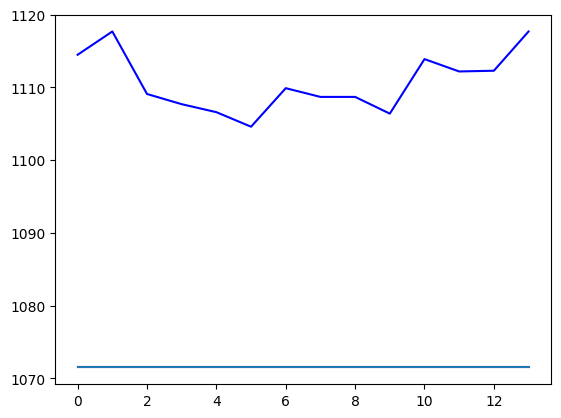

In [112]:
plt.plot(model.scaler.inverse_transform(prediction).reshape(-1), c='r')
plt.plot(batch_data.future_target_cdf.reshape(-1), c='b')
plt.plot(model.scaler.inverse_transform(future_target_cdf).reshape(-1))

In [78]:
batch_data.past_target_cdf.shape

torch.Size([1, 86, 2000])

ValueError: x and y must have same first dimension, but have shapes (14,) and (1, 2000)

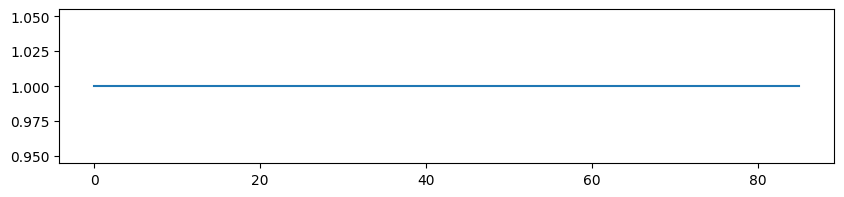

In [79]:
context_length = data_manager.context_length
prediction_length = data_manager.prediction_length
past_range = range(0, context_length)
future_range = range(context_length, context_length + prediction_length)
full_range = range(0, context_length + prediction_length)

for i in range(min(10, forecaster.target_dim)):
    target = torch.cat([past_target_cdf[batch_idx, -context_length:, i], future_target_cdf[batch_idx, :, i]])
    plt.figure(figsize=(10, 2))
    plt.plot(full_range, target)
    plt.plot(future_range, prediction[:, i])

In [ ]:
trainer.test(model=model, datamodule=data_module);

In [ ]:
future_target_cdf.shape